## The purpose of this exercise is to learn and practice machine learning standard process
- Use the most naive implementation
- Do not do any advanced feature selection
- Model evaluation is only one step to familize the entire process of ML

In [124]:
# Import Libraries
import pandas as pd
import numpy as np
import zipfile
from pathlib import Path
import seaborn as sns
from sklearn.preprocessing import StandardScaler, RobustScaler, LabelEncoder
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import VotingClassifier, RandomTreesEmbedding, RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import SGDClassifier
from sklearn.impute import KNNImputer, SimpleImputer
from sklearn.dummy import DummyClassifier
from sklearn.feature_selection import RFECV
from sklearn.metrics import confusion_matrix, accuracy_score, recall_score, precision_score, roc_curve, precision_recall_curve, auc, make_scorer, average_precision_score, roc_auc_score
#from sklearn.compose import make_column_transformer

import matplotlib.pyplot as plt
%matplotlib inline

In [125]:
# import training data=
root = Path(".")
with zipfile.ZipFile(root/"titanic.zip") as z:
    names = z.namelist()
    df_train = pd.read_csv(z.open(names[2]))
    x_df_test = pd.read_csv(z.open(names[1]))
    y_df_test = pd.read_csv(z.open(names[0]))
    y_df_test = y_df_test.drop(columns=['PassengerId'])
    
df_test = pd.concat([x_df_test, y_df_test],axis=1)
df_data = pd.concat([df_train, df_test], axis=0)


In [126]:
df_data.describe()

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare
count,1309.000000,1309.000000,1309.000000,1046.000000,1309.000000,1309.000000,1308.000000
mean,655.000000,0.377387,2.294882,29.881138,0.498854,0.385027,33.295479
std,378.020061,0.484918,0.837836,14.413493,1.041658,0.865560,51.758668
min,1.000000,0.000000,1.000000,0.170000,0.000000,0.000000,0.000000
25%,328.000000,0.000000,2.000000,21.000000,0.000000,0.000000,7.895800
50%,655.000000,0.000000,3.000000,28.000000,0.000000,0.000000,14.454200
75%,982.000000,1.000000,3.000000,39.000000,1.000000,0.000000,31.275000
max,1309.000000,1.000000,3.000000,80.000000,8.000000,9.000000,512.329200


In [127]:
df_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1309 entries, 0 to 417
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  1309 non-null   int64  
 1   Survived     1309 non-null   int64  
 2   Pclass       1309 non-null   int64  
 3   Name         1309 non-null   object 
 4   Sex          1309 non-null   object 
 5   Age          1046 non-null   float64
 6   SibSp        1309 non-null   int64  
 7   Parch        1309 non-null   int64  
 8   Ticket       1309 non-null   object 
 9   Fare         1308 non-null   float64
 10  Cabin        295 non-null    object 
 11  Embarked     1307 non-null   object 
dtypes: float64(2), int64(5), object(5)
memory usage: 132.9+ KB


### Remove the unused variables

In [128]:
# drop the variables that varies too much --> not providing much information
drop_var = ['PassengerId', "Name", "Ticket", "Cabin"]
df_data = df_data.drop(drop_var, axis=1)

### Fill the missing variables

In [129]:
dict_fill_age = df_data.groupby("Sex")["Age"].mean().to_dict()

for gender, fill_age in dict_fill_age.items():
    df_data.loc[(df_data.Sex==gender) & (df_data.Age.isna()), "Age"] = fill_age


In [ ]:
df_data.Fare = df_data.Fare.fillna(value=df_data.Fare.median())

In [131]:
SI = SimpleImputer(strategy="most_frequent")
df_data.Embarked = SI.fit_transform(df_data[['Embarked']])

### Encode the categorical variables to numeric variables

In [132]:
df_data["Sex_encoded"] = df_data.Sex.map({"male": 0, "female":1}).astype('int8')


In [135]:
label_encoder = LabelEncoder()
df_data["Embarked_encoded"] = label_encoder.fit_transform(df_data.Embarked).astype('int8')

In [136]:
df_data.info()
df_data.describe()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1309 entries, 0 to 417
Data columns (total 10 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   Survived          1309 non-null   int64  
 1   Pclass            1309 non-null   int64  
 2   Sex               1309 non-null   object 
 3   Age               1309 non-null   float64
 4   SibSp             1309 non-null   int64  
 5   Parch             1309 non-null   int64  
 6   Fare              1309 non-null   float64
 7   Embarked          1309 non-null   object 
 8   Sex_encoded       1309 non-null   int8   
 9   Embarked_encoded  1309 non-null   int8   
dtypes: float64(2), int64(4), int8(2), object(2)
memory usage: 94.6+ KB


,Survived,Pclass,Age,SibSp,Parch,Fare,Sex_encoded,Embarked_encoded
count,1309.000000,1309.000000,1309.000000,1309.000000,1309.000000,1309.000000,1309.000000,1309.000000
mean,0.377387,2.294882,29.909496,0.498854,0.385027,33.281086,0.355997,1.493506
std,0.484918,0.837836,12.889182,1.041658,0.865560,51.741500,0.478997,0.814244
min,0.000000,1.000000,0.170000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,2.000000,22.000000,0.000000,0.000000,7.895800,0.000000,1.000000
50%,0.000000,3.000000,30.000000,0.000000,0.000000,14.454200,0.000000,2.000000
75%,1.000000,3.000000,35.000000,1.000000,0.000000,31.275000,1.000000,2.000000
max,1.000000,3.000000,80.000000,8.000000,9.000000,512.329200,1.000000,2.000000


### Define a pipeline and grid search

In [364]:
scaler = StandardScaler()
est = KNeighborsClassifier(n_neighbors=10)

scoring = {"recall": make_scorer(recall_score, greater_is_better=True),
           "precision": make_scorer(precision_score, greater_is_better=True),
           "accuracy": make_scorer(accuracy_score, greater_is_better=True),
           #'ROC_AUC': make_scorer(roc_auc_score, greater_is_better=True, needs_proba=True)
           }

pipe = Pipeline(
                steps=[("scaler", scaler), ("est", est)]
)

grid = GridSearchCV(pipe,
                    param_grid={"est__n_neighbors": [i for i in range(1,100)]},
                    n_jobs= -1,
                    scoring= scoring,
                    refit="accuracy",
                    return_train_score=True,
                    cv=10
                    )

In [365]:
train_cols = ['Pclass', 'Age', 'SibSp', 'Parch', 'Fare', 'Sex_encoded', 'Embarked_encoded']

df_train = df_data.iloc[:df_train.shape[0],:]
df_test  = df_data.iloc[df_train.shape[0]:,:]
grid.fit(df_train[train_cols], df_train["Survived"])

GridSearchCV(cv=10,
             estimator=Pipeline(steps=[('scaler', StandardScaler()),
                                       ('est',
                                        KNeighborsClassifier(n_neighbors=10))]),
             n_jobs=-1,
             param_grid={'est__n_neighbors': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11,
                                              12, 13, 14, 15, 16, 17, 18, 19,
                                              20, 21, 22, 23, 24, 25, 26, 27,
                                              28, 29, 30, ...]},
             refit='accuracy', return_train_score=True,
             scoring={'accuracy': make_scorer(accuracy_score),
                      'precision': make_scorer(precision_score),
                      'recall': make_scorer(recall_score)})

In [366]:
df_grid = pd.DataFrame(grid.cv_results_)
df_grid

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_est__n_neighbors,params,split0_test_recall,split1_test_recall,split2_test_recall,split3_test_recall,...,split2_train_accuracy,split3_train_accuracy,split4_train_accuracy,split5_train_accuracy,split6_train_accuracy,split7_train_accuracy,split8_train_accuracy,split9_train_accuracy,mean_train_accuracy,std_train_accuracy
0,0.026345,0.022304,0.052879,0.028868,1,{'est__n_neighbors': 1},0.685714,0.676471,0.558824,0.735294,...,0.986284,0.982544,0.977556,0.972569,0.981297,0.983791,0.980050,0.981297,0.981045,0.003561
1,0.029485,0.015463,0.038222,0.011623,2,{'est__n_neighbors': 2},0.514286,0.588235,0.500000,0.676471,...,0.896509,0.884040,0.875312,0.879052,0.881546,0.886534,0.884040,0.885287,0.884150,0.005398
2,0.032762,0.034106,0.066337,0.031468,3,{'est__n_neighbors': 3},0.685714,0.764706,0.529412,0.823529,...,0.886534,0.879052,0.871571,0.876559,0.875312,0.876559,0.871571,0.865337,0.875796,0.005729
3,0.027701,0.021440,0.050076,0.016135,4,{'est__n_neighbors': 4},0.571429,0.647059,0.500000,0.735294,...,0.866584,0.856608,0.864090,0.851621,0.856608,0.860349,0.856608,0.856608,0.858461,0.004175
4,0.024196,0.010178,0.040024,0.015380,5,{'est__n_neighbors': 5},0.628571,0.647059,0.500000,0.882353,...,0.870324,0.859102,0.857855,0.856608,0.862843,0.852868,0.856608,0.849127,0.858711,0.005777
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
94,0.034140,0.028393,0.069149,0.034665,95,{'est__n_neighbors': 95},0.657143,0.735294,0.588235,0.852941,...,0.800499,0.790524,0.801746,0.798005,0.799252,0.794264,0.795511,0.800499,0.796233,0.004225
95,0.038719,0.033399,0.112528,0.037434,96,{'est__n_neighbors': 96},0.657143,0.735294,0.588235,0.852941,...,0.800499,0.789277,0.801746,0.799252,0.796758,0.796758,0.794264,0.800499,0.796608,0.003776
96,0.027860,0.033116,0.087556,0.036945,97,{'est__n_neighbors': 97},0.657143,0.735294,0.588235,0.852941,...,0.799252,0.790524,0.798005,0.798005,0.798005,0.791771,0.793017,0.796758,0.794862,0.003241
97,0.028291,0.027340,0.065816,0.012837,98,{'est__n_neighbors': 98},0.657143,0.735294,0.588235,0.852941,...,0.800499,0.790524,0.800499,0.800499,0.796758,0.794264,0.794264,0.799252,0.796608,0.003367


In [367]:
pipe.fit(df_train[train_cols], df_train["Survived"])

Pipeline(steps=[('scaler', StandardScaler()),
                ('est', KNeighborsClassifier(n_neighbors=10))])

In [368]:
df_grid.loc[9]

mean_fit_time             0.020642
std_fit_time              0.010519
mean_score_time           0.043718
std_score_time            0.023708
param_est__n_neighbors          10
                            ...   
split7_train_accuracy     0.841646
split8_train_accuracy     0.835411
split9_train_accuracy     0.837905
mean_train_accuracy       0.836513
std_train_accuracy        0.005607
Name: 9, Length: 81, dtype: object

In [369]:
print("ROC_AUC: ", roc_auc_score(df_train["Survived"], pipe.predict_proba(df_train[train_cols])[:,1]))
print("PR AUC: ", average_precision_score(df_train["Survived"], pipe.predict_proba(df_train[train_cols])[:,1]))

ROC_AUC:  0.9120410315406002
PR AUC:  0.8644647187519228


In [370]:
fpr, tpr, threshold_roc = roc_curve(df_train["Survived"], pipe.predict_proba(df_train[train_cols])[:,1])
print("ROC AUC: ", auc(fpr, tpr))

precision, recall, threshold_pr = precision_recall_curve(df_train["Survived"], pipe.predict_proba(df_train[train_cols])[:,1])
print("PR AUC: ", auc(recall, precision))

ROC AUC:  0.9120410315406002
PR AUC:  0.8861588493301293


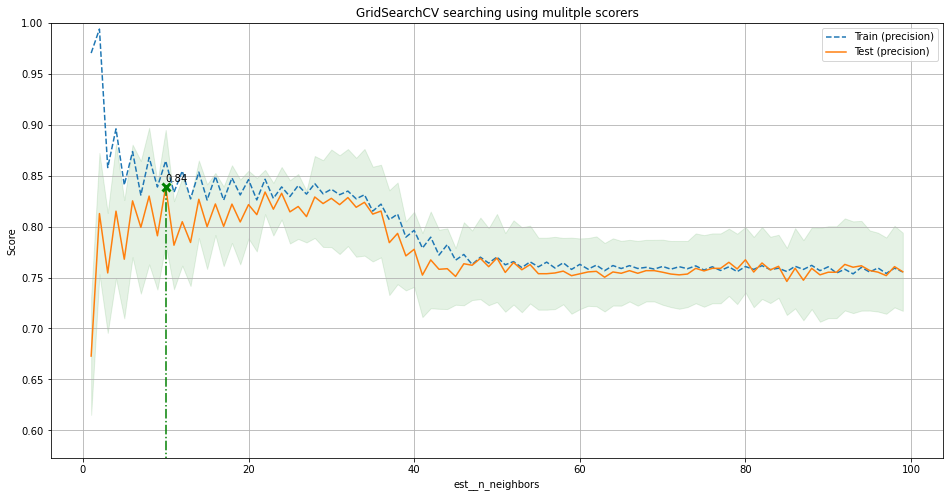

In [371]:
fig, ax = plt.subplots(figsize=(16,8))
ax.set_title("GridSearchCV searching using mulitple scorers")
ax.set_xlabel("est__n_neighbors")
ax.set_ylabel("Score")

ax.plot(df_grid['param_est__n_neighbors'], df_grid['mean_train_precision'], linestyle='--', label="Train (precision)")
ax.plot(df_grid['param_est__n_neighbors'], df_grid['mean_test_precision'], linestyle='-', label="Test (precision)")
#X_axis = np.array(grid.cv_results_["param_est__n_neighbors"].data, dtype=float)


best_index, best_score = df_grid["mean_test_precision"].argmax(), df_grid["mean_test_precision"].max()
ax.annotate(f'{best_score:0.2}', (df_grid["param_est__n_neighbors"][best_index], best_score + 0.005))
ax.plot([df_grid["param_est__n_neighbors"][best_index]]*2, [0, best_score], "-.", color="g", marker='x', markersize=8, markeredgewidth=3)

ax.fill_between(df_grid['param_est__n_neighbors'].astype(int), 
                df_grid['mean_test_precision'].astype(float) + df_grid["std_test_precision"].astype(float), 
                df_grid['mean_test_precision'].astype(float) - df_grid["std_test_precision"].astype(float), 
                alpha=0.1, 
                color='g')

lowest_score = df_grid['mean_test_precision'].min()
plt.ylim((lowest_score - 0.1, 1))
plt.legend(loc='best')
plt.grid()
plt.show()

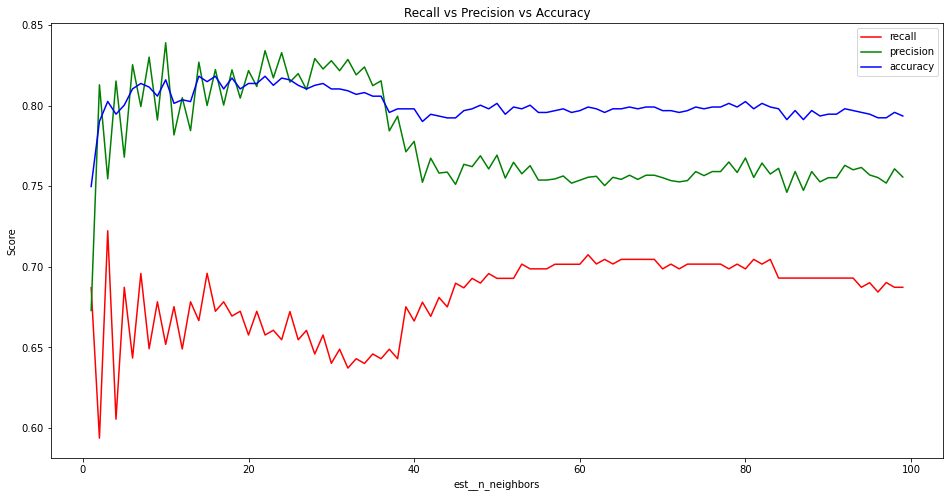

In [392]:
plt.figure(figsize=(16, 8))

for metric, color in zip(['recall', 'precision', 'accuracy'], ['r', 'g', 'b']):
    plt.plot(df_grid['param_est__n_neighbors'].astype(int), df_grid[f'mean_test_{metric}'], c=color, label=metric)

plt.title("Recall vs Precision vs Accuracy")
plt.ylabel("Score")
plt.xlabel("est__n_neighbors")
plt.legend(loc='best')
plt.show()